### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Nov 25 12:35:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [3]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.37 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.5/112.6 GB disk)


In [4]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets




!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="UynPSQgEXONS23dKJYtP")
project = rf.workspace("mrudula").project("patient-detector")
version = project.version(1)
dataset = version.download("yolov11")


/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to patient-detector-1 in yolov11:: 100%|██████████| 500/500 [00:00<00:00, 4643.27it/s]


## Custom Training

In [5]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s-seg.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
100% 19.7M/19.7M [00:00<00:00, 169MB/s]
WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.37 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolo11s-seg.pt, data=/content/datasets/patient-detector-1/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualiz

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [6]:
!ls {HOME}/runs/segment/train/

args.yaml					   labels_correlogram.jpg  train_batch0.jpg
BoxF1_curve.png					   labels.jpg		   train_batch1.jpg
BoxP_curve.png					   MaskF1_curve.png	   train_batch2.jpg
BoxPR_curve.png					   MaskP_curve.png	   val_batch0_labels.jpg
BoxR_curve.png					   MaskPR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			   MaskR_curve.png	   val_batch1_labels.jpg
confusion_matrix.png				   results.csv		   val_batch1_pred.jpg
events.out.tfevents.1732538255.eb82c73bd046.945.0  results.png		   weights


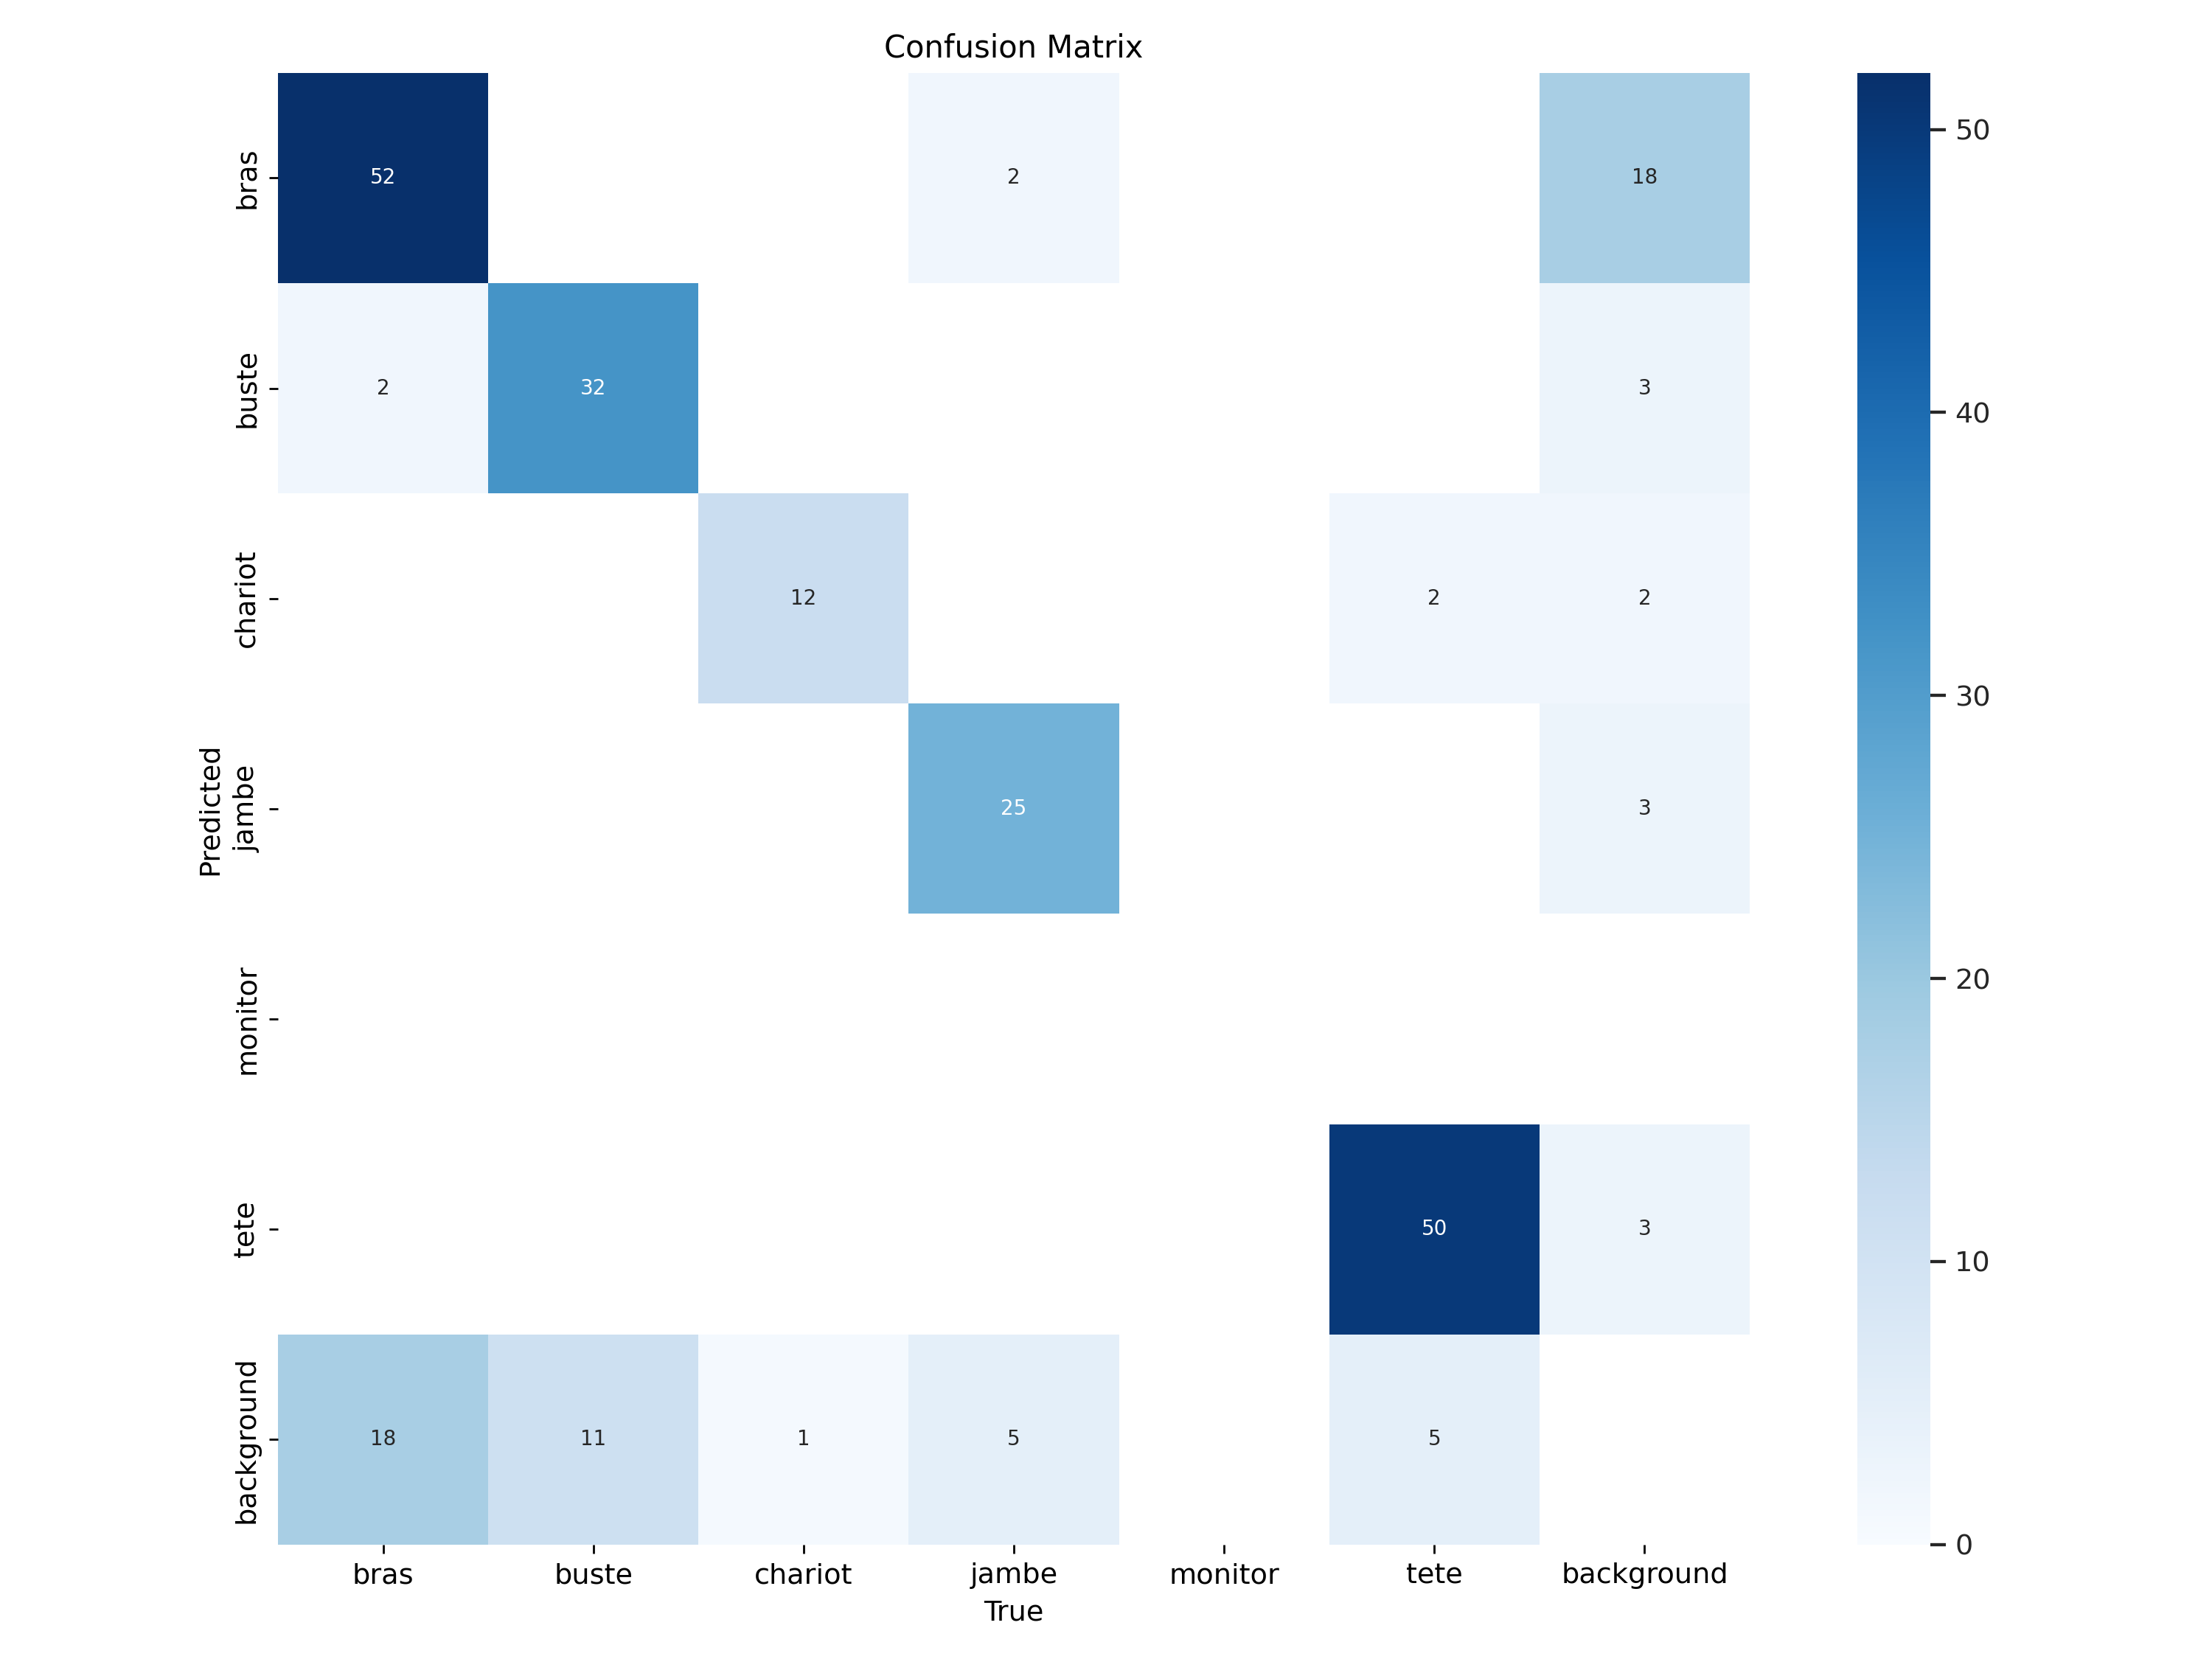

In [7]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/confusion_matrix.png', width=600)

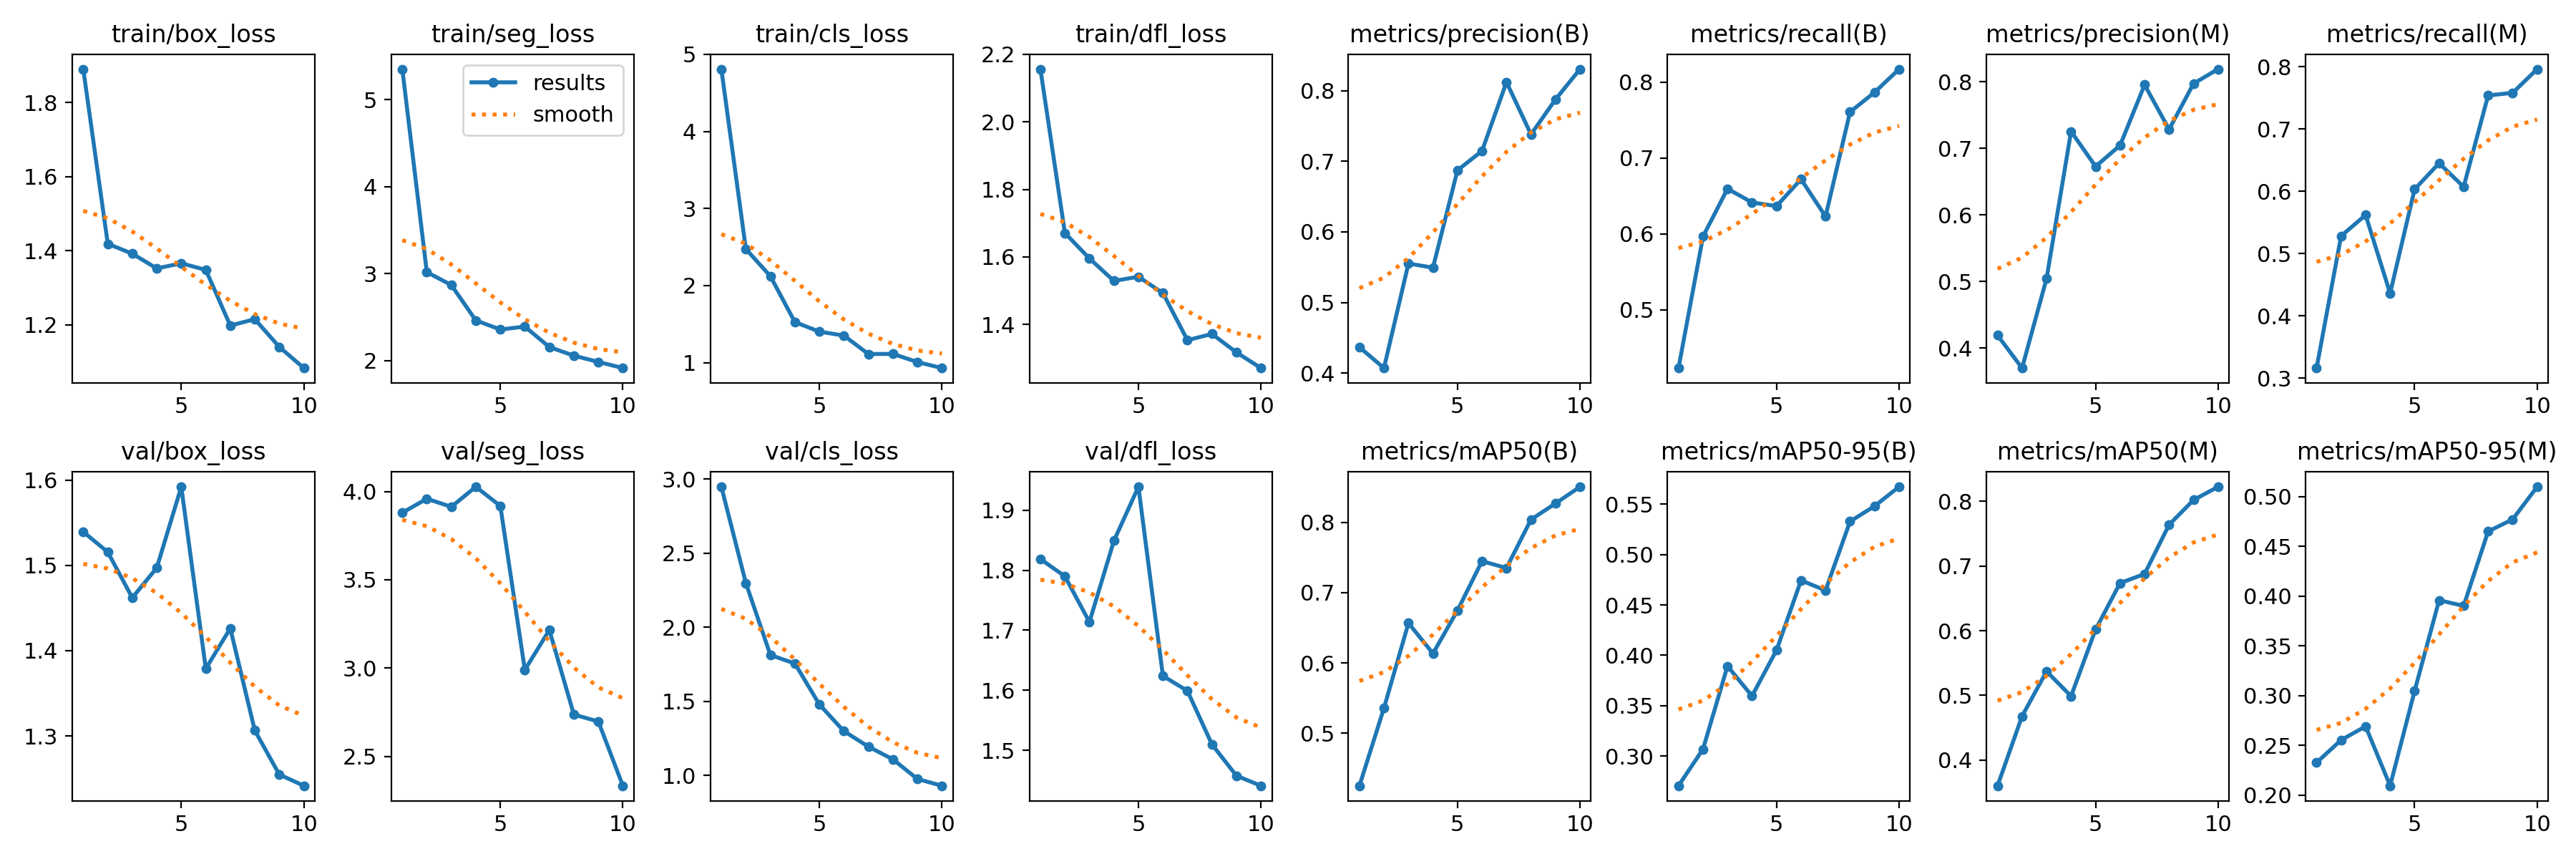

In [8]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/results.png', width=600)

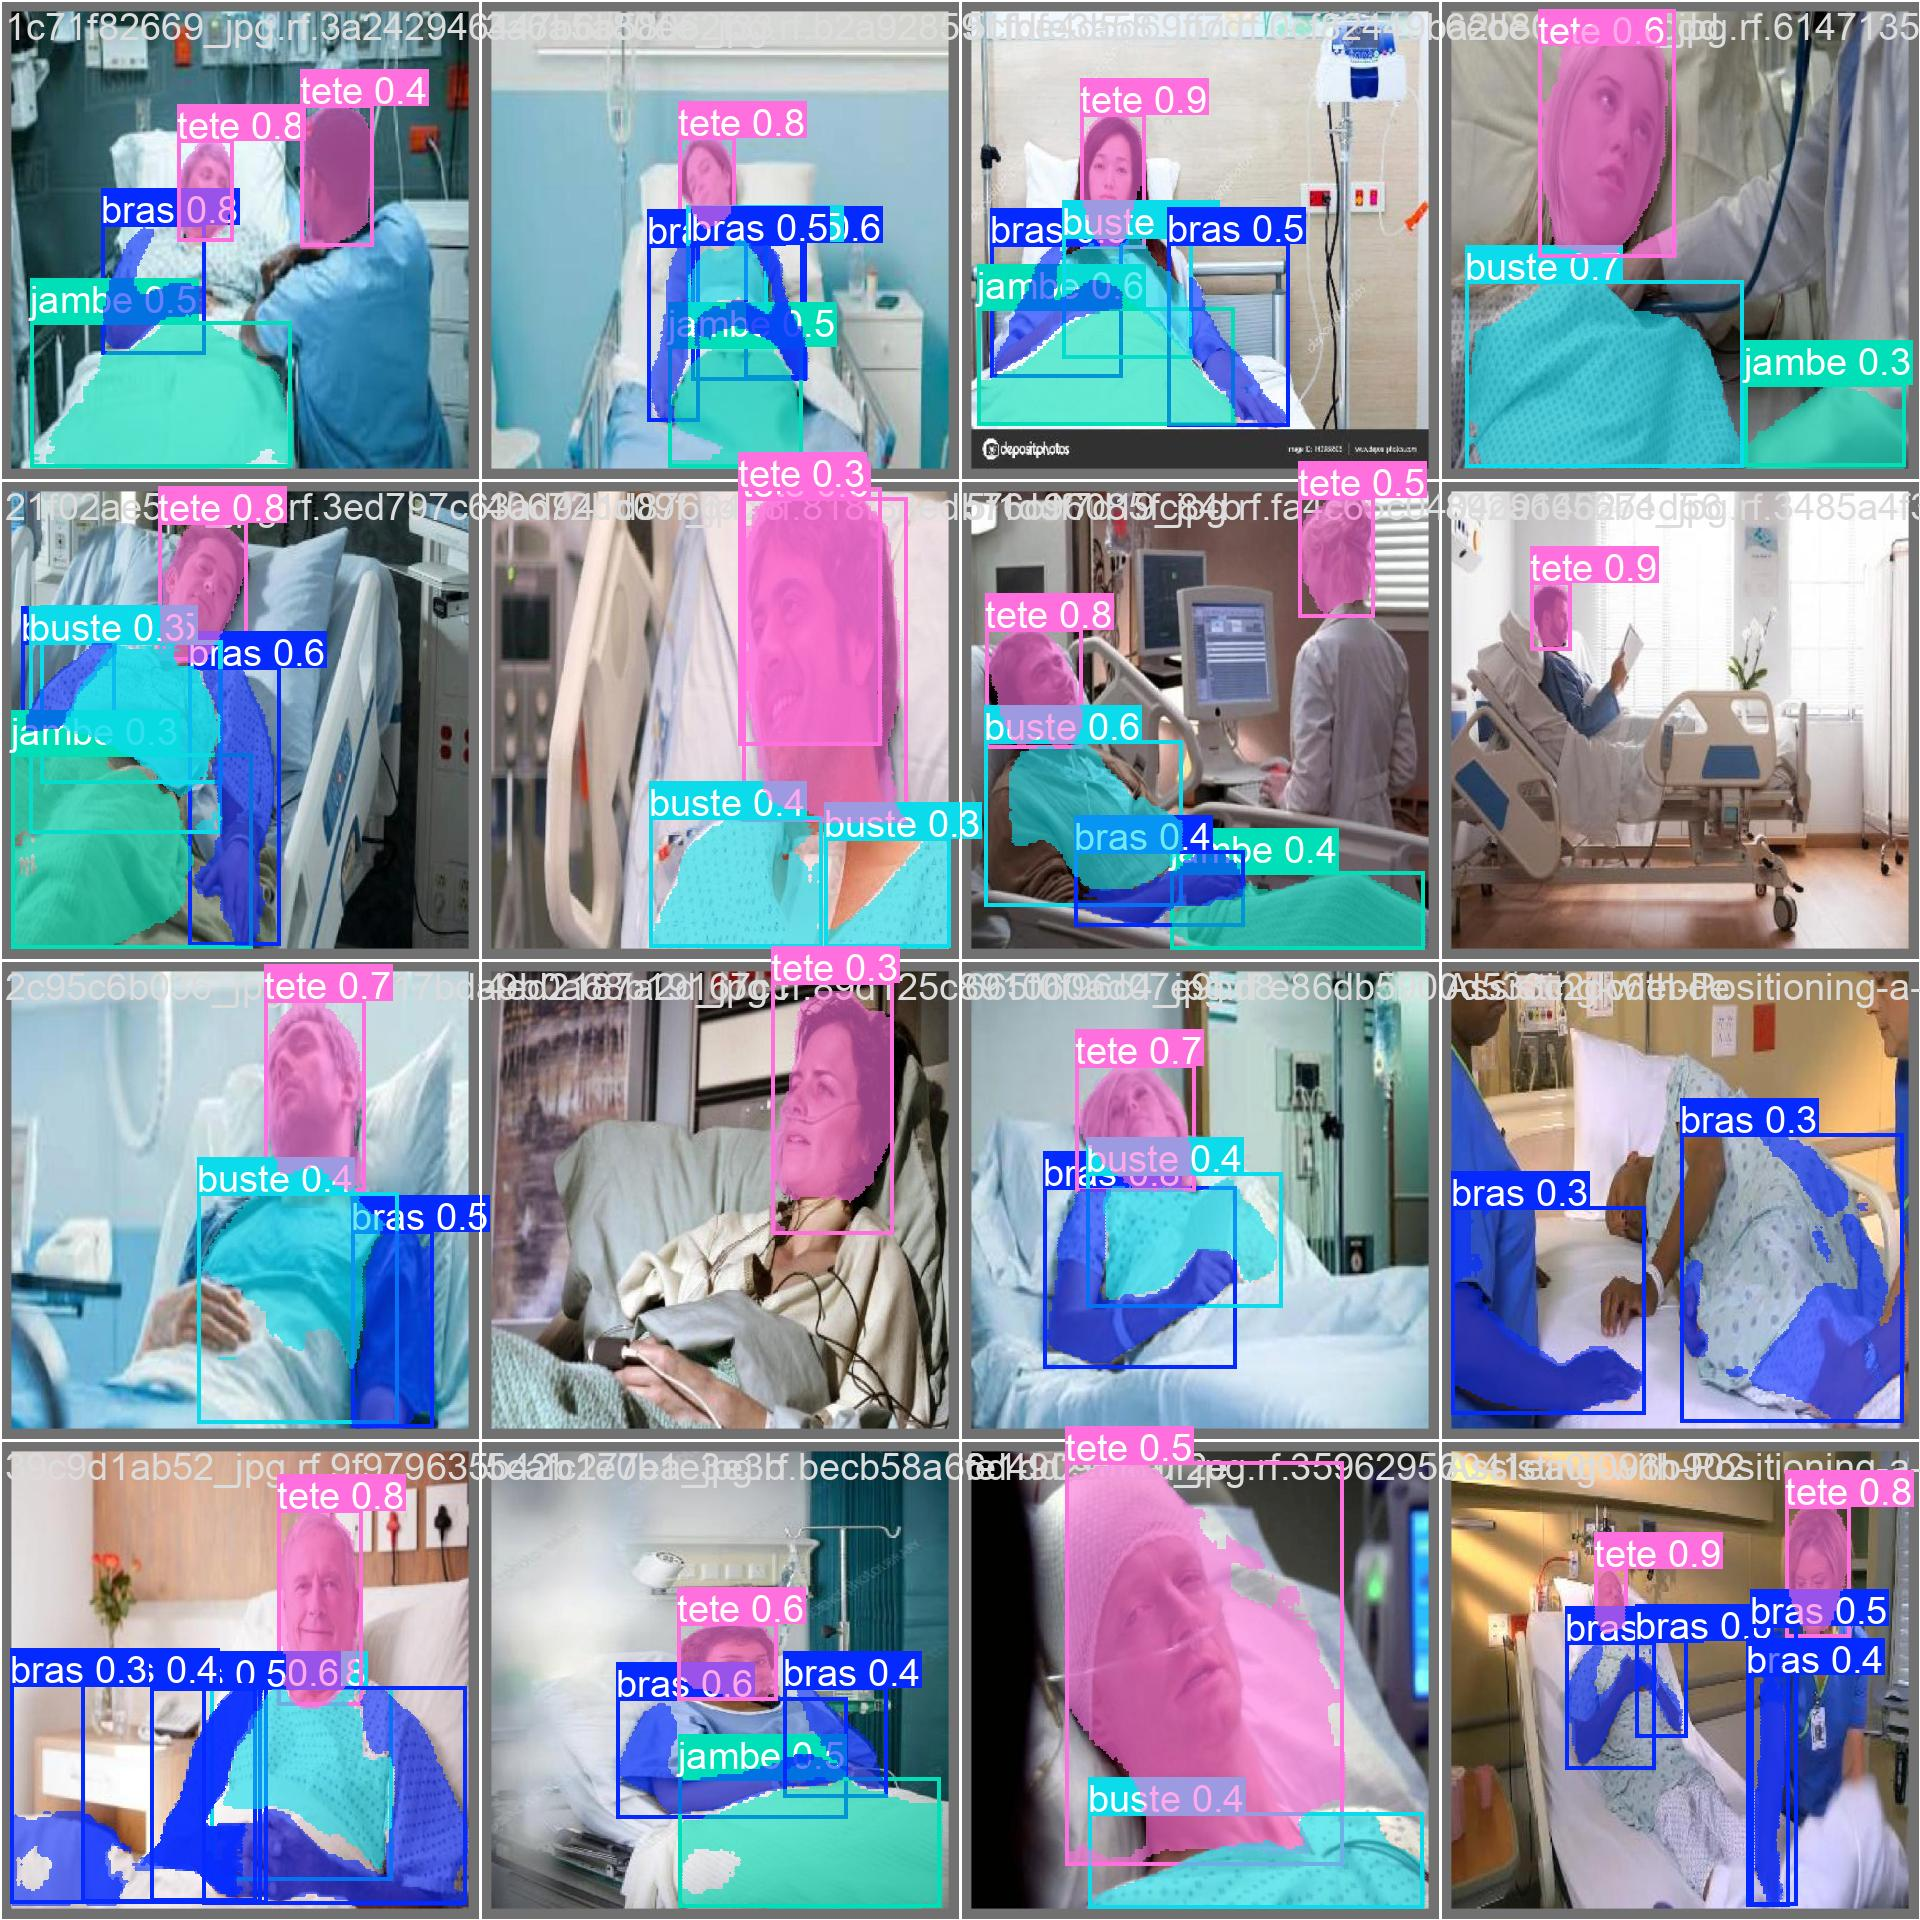

In [9]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [10]:
!yolo task=detect mode=val model={HOME}/runs/segment/train/weights/best.pt data={dataset.location}/data.yaml

WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.37 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s-seg summary (fused): 265 layers, 10,069,138 parameters, 0 gradients, 35.3 GFLOPs
val: Scanning /content/datasets/patient-detector-1/valid/labels.cache... 46 images, 0 backgrounds, 0 corrupt: 100% 46/46 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 3/3 [00:03<00:00,  1.20s/it]
                   all         46        217      0.832      0.821      0.851      0.567      0.818      0.796      0.819      0.507
                  bras         41         72      0.744       0.75      0.822      0.508       0.72      0.714      0.749      0.327
                 buste         43         43      0.868      0.767      0.876      0.496      0.839      0.728      

## Inference with custom model

In [11]:
!yolo task=detect mode=predict model={HOME}/runs/segment/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.37 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s-seg summary (fused): 265 layers, 10,069,138 parameters, 0 gradients, 35.3 GFLOPs

image 1/21 /content/datasets/patient-detector-1/test/images/015aeaff34_jpg.rf.3bdc90d8824fdbe6da2be8d834d096f5.jpg: 640x640 1 bras, 1 jambe, 2 tetes, 20.2ms
image 2/21 /content/datasets/patient-detector-1/test/images/1587ee6fd3_jpg.rf.dce8899d2c76548cbd267a34e7cdb306.jpg: 640x640 3 brass, 1 jambe, 1 tete, 20.2ms
image 3/21 /content/datasets/patient-detector-1/test/images/1776f5b746_jpg.rf.04508ea7380821995379f375aab2cbc5.jpg: 640x640 3 brass, 1 buste, 1 jambe, 1 tete, 20.2ms
image 4/21 /content/datasets/patient-detector-1/test/images/2fb605f183_jpg.rf.d60b2048b5a7d9e99283483cdcba905d.jpg: 640x640 2 brass, 1 jambe, 20.1ms
image 5/21 /content/datasets/patient-detector-1/test/image

**NOTE:** Let's take a look at few results.

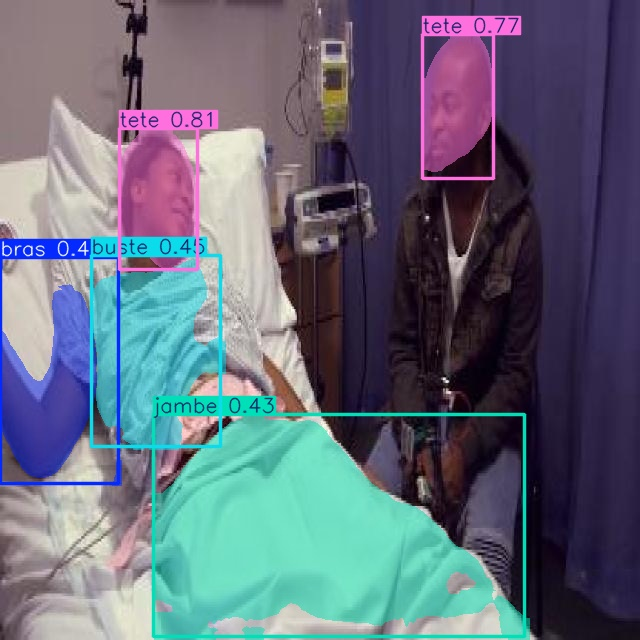

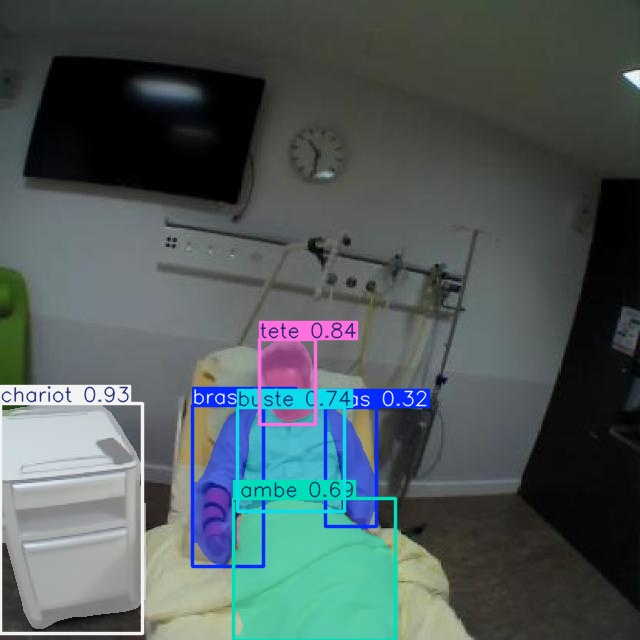

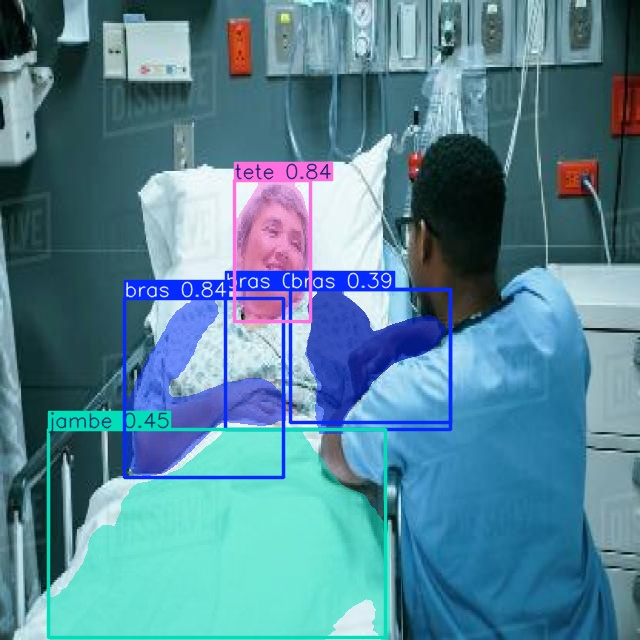

In [12]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/segment/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")